In [ ]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statistics as stats
import random as rn
import os
import tensorflow.compat.v1 as tf
import keras
import warnings

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, GaussianNoise, GaussianDropout
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.regularizers import l1, l2, l1_l2
from keras.activations import relu
from keras import initializers as init
from keras.constraints import max_norm
from keras.utils.vis_utils import plot_model
from tensorflow.compat.v1.keras import backend as K
from math import sqrt
from IPython.display import display
from matplotlib.lines import Line2D
from collections import defaultdict
from IPython.display import Image
from google.colab import files, drive
#drive.mount("drive")

# ensure repeatability
K.clear_session()
tf.reset_default_graph()
warnings.filterwarnings("ignore")

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(23)
rn.seed(23)
tf.random.set_random_seed(23)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

pd.set_option("display.max_columns", None)

In [ ]:
# load df
df = pd.read_csv("TL_trainset.csv", index_col=0)
df_full = pd.read_csv("fullchem.csv", index_col=0)
labels = pd.read_csv("TL_labels.csv", sep="|")
labels.head()

,Type,AB,Site,Impurity
0,IV-IV,GeC,M_i_neut,Cl
1,III-V,BAs,M_i_neut,Te
2,IV-IV,GeC,M_i_B,Cd
3,III-V,BP,M_i_B,Zr
4,III-V,GaN,M_B,Ag


In [ ]:
# code to test for inf or na in pandas df
a = df.isna().any()
j = 0
k = 0
z = 0
for i in range(df.shape[1]):
    b = str(a[i])
    if b is "True":
        k+=1
    elif b is "False":
        j+=1
    else:
        z+=1

print(k)
print(j)
print(z)

# code to test for inf or na in pandas df
a = df_full.isna().any()
j = 0
k = 0
z = 0
for i in range(df_full.shape[1]):
    b = str(a[i])
    if b is "True":
        k+=1
    elif b is "False":
        j+=1
    else:
        z+=1

print(k)
print(j)
print(z)

0
515
0
0
736
0


In [ ]:
class NeuralNetwork:
    def data_prep(df):
        """
        Function adds two additional descriptor columns for sc type and defect
        site, then standardized and one-hot encodes input and output
        """
        # load labels df - sc type, defect site, compound
        labels = pd.read_csv("TL_labels.csv", sep="|")
        labels.drop(columns=labels.iloc[:, 1:2], inplace=True)
        labels.drop(columns=labels.iloc[:, 2:3], inplace=True)
        
        # encode sc type and defect site and add to df
        enc = OrdinalEncoder(dtype=np.int)        
        enc_labels = enc.fit_transform(labels)
        labels = pd.DataFrame(enc_labels, columns=["Type", "Site"])
        df = pd.concat([df, labels], axis=1)

        # separate categorical and continuous data 
        categorical=pd.DataFrame()
        continuous=pd.DataFrame()

        # seperate x and y values
        y = df.iloc[:, 0:6]
        x = df.iloc[:, 6:1000000]

        for column in x.columns:
            if(x[column].dtypes == "int"):
                categorical[column]=x[column]
            elif(x[column].dtypes == "float"):
                continuous[column]=x[column]
            else:
                pass
                
        # one hot encode categorical data
        onehotencoder = OneHotEncoder()
        categorical = onehotencoder.fit_transform(categorical).toarray()
   
        # standardize continuous data
        input_scaler = StandardScaler()
        continuous = input_scaler.fit_transform(continuous)

        # re-combine categorical and continuous x values
        x = np.concatenate((continuous, categorical), axis=1)

        # standardize outputs (DFT predicted / output)
        output_scaler = StandardScaler()
        y = output_scaler.fit_transform(y)

        # concatenate x and y back to df
        df = pd.DataFrame(np.concatenate((y, x), axis=1))

        return (df, output_scaler, input_scaler)

    def graph_results(epochs, loss, val_loss, training_results,
                      testing_results):
    
        test_color = "#ff5042"  #red 
        train_color = "#080bb6"  #blue
        error_color = "#bababa"  #grey
        fig, ax = plt.subplots(figsize=(12, 7))
        x_plot = np.arange(0, epochs)
        for index in range(loss.shape[0]):
            ax.plot(x_plot, loss[index], label="Training Loss", color=train_color, 
                    lw=2)
            ax.plot(x_plot, val_loss[index], label="Validation Loss",
                    color=test_color, lw=2)
        ax.set_xlabel("Epoch Number", fontsize=15)
        ax.set_ylabel("Loss", fontsize=15)
        ax.set_ylim(0, 3)
        ax.set_title('Training/Validation Loss Functions', fontsize=20)
        legend_lines = [Line2D([0], [0], color=train_color, lw=4),
                        Line2D([0], [0], color=test_color, lw=4)]                                
        ax.legend(legend_lines, ["Loss", "Val. Loss"], fontsize=20)
        plt.show()

        #############################################################
        # plot results
        fig, ax = plt.subplots(2, 3, figsize=(22, 10))
        fig.subplots_adjust(hspace=.25, wspace = 0.175, top=.90)
        fig.suptitle("Transition Levels: NN Predictions VS. DFT Calc.", 
                     fontsize=20, va='top')
        fig.text(0.5, 0.05, 'DFT Calculations (eV)', ha='center', fontsize=17)
        fig.text(0.075, 0.5, 'Neural Network Prediction (eV)', va='center', 
                 rotation='vertical', fontsize=17)
        
        subtitle_size = 17
        test_alpha = 0.5
        train_alpha = 0.85
        scatter_size = 6.5

        # P32
        ax[0,0].set_title("Transition Level: (+3/+2)", fontsize=subtitle_size)
        ax[0,0].errorbar(training_results["+3/+2 DFT"],
                         training_results["+3/+2 NN"],
                         yerr=training_results["+3/+2 Error"], fmt='o',
                         label="Train", ecolor=error_color, elinewidth=2.5,
                         alpha=train_alpha, color=train_color,
                         markersize=scatter_size, zorder=3)        
        ax[0,0].errorbar(testing_results["+3/+2 DFT"],
                         testing_results["+3/+2 NN"],
                         yerr=testing_results["+3/+2 Error"], fmt='o',
                         label="Test", ecolor=error_color, elinewidth=2.5,
                         alpha=test_alpha, color=test_color,
                         markersize=scatter_size, zorder=3)        
        lims = [np.min([ax[0,0].get_xlim(), ax[0,0].get_ylim()]),
                np.max([ax[0,0].get_xlim(), ax[0,0].get_ylim()])]
        ax[0,0].plot(lims, lims, color="black", zorder=3, alpha=0.7)
        ax[0,0].set_xlim(lims)
        ax[0,0].set_ylim(lims)
        ax[0,0].legend(fontsize=subtitle_size)

        # P21
        ax[1,0].set_title("Transition Level: (+2/+1)", fontsize=subtitle_size)
        ax[1,0].errorbar(training_results["+2/+1 DFT"],
                         training_results["+2/+1 NN"],
                         yerr=training_results["+2/+1 Error"], fmt='o',
                         label="Train", ecolor=error_color, elinewidth=2.5,
                         alpha=train_alpha, color=train_color,
                         markersize=scatter_size, zorder=3)     
        ax[1,0].errorbar(testing_results["+2/+1 DFT"],
                         testing_results["+2/+1 NN"],
                         yerr=testing_results["+2/+1 Error"], fmt='o',
                         label="Test", ecolor=error_color, elinewidth=2.5,
                         alpha=test_alpha, color=test_color,
                         markersize=scatter_size, zorder=3)     
        lims = [np.min([ax[1,0].get_xlim(), ax[1,0].get_ylim()]),
                np.max([ax[1,0].get_xlim(), ax[1,0].get_ylim()])]
        ax[1,0].plot(lims, lims, color="black", zorder=3, alpha=0.7)
        ax[1,0].set_xlim(lims)
        ax[1,0].set_ylim(lims)
        
        # P10
        ax[0,1].set_title("Transition Level: (+1/0)", fontsize=subtitle_size)
        ax[0,1].errorbar(training_results["+1/0 DFT"],
                         training_results["+1/0 NN"],
                         yerr=training_results["+1/0 Error"], fmt='o',
                         label="Train", ecolor=error_color, elinewidth=2.5,
                         alpha=train_alpha, color=train_color,
                         markersize=scatter_size, zorder=3)       
        ax[0,1].errorbar(testing_results["+1/0 DFT"],
                         testing_results["+1/0 NN"],
                         yerr=testing_results["+1/0 Error"], fmt='o',
                         label="Test", ecolor=error_color, elinewidth=2.5,
                         alpha=test_alpha, color=test_color,
                         markersize=scatter_size, zorder=3)     
        lims = [np.min([ax[0,1].get_xlim(), ax[0,1].get_ylim()]),
                np.max([ax[0,1].get_xlim(), ax[0,1].get_ylim()])]
        ax[0,1].plot(lims, lims, color="black", zorder=3, alpha=0.7)
        ax[0,1].set_xlim(lims)
        ax[0,1].set_ylim(lims)
        
        # N01
        ax[1,1].set_title("Transition Level: (0/-1)", fontsize=subtitle_size)
        ax[1,1].errorbar(training_results["0/-1 DFT"],
                         training_results["0/-1 NN"],
                         yerr=training_results["0/-1 Error"], fmt='o',
                         label="Train", ecolor=error_color, elinewidth=2.5,
                         alpha=train_alpha, color=train_color,
                         markersize=scatter_size, zorder=3)    
        ax[1,1].errorbar(testing_results["0/-1 DFT"],
                         testing_results["0/-1 NN"],
                         yerr=testing_results["0/-1 Error"], fmt='o',
                         label="Test", ecolor=error_color, elinewidth=2.5,
                         alpha=test_alpha, color=test_color,
                         markersize=scatter_size, zorder=3)     
        lims = [np.min([ax[1,1].get_xlim(), ax[1,1].get_ylim()]),
                np.max([ax[1,1].get_xlim(), ax[1,1].get_ylim()])]
        ax[1,1].plot(lims, lims, color="black", zorder=3, alpha=0.7)
        ax[1,1].set_xlim(lims)
        ax[1,1].set_ylim(lims)
        
        # N12
        ax[0,2].set_title("Transition Level: (-1/-2)", fontsize=subtitle_size)
        ax[0,2].errorbar(training_results["-1/-2 DFT"],
                         training_results["-1/-2 NN"],
                         yerr=training_results["-1/-2 Error"], fmt='o',
                         label="Train", ecolor=error_color, elinewidth=2.5,
                         alpha=train_alpha, color=train_color,
                         markersize=scatter_size, zorder=3) 
        ax[0,2].errorbar(testing_results["-1/-2 DFT"],
                         testing_results["-1/-2 NN"],
                         yerr=testing_results["-1/-2 Error"], fmt='o',
                         label="Test", ecolor=error_color, elinewidth=2.5,
                         alpha=test_alpha, color=test_color,
                         markersize=scatter_size, zorder=3)           
        lims = [np.min([ax[0,2].get_xlim(), ax[0,2].get_ylim()]),
                np.max([ax[0,2].get_xlim(), ax[0,2].get_ylim()])]
        ax[0,2].plot(lims, lims, color="black", zorder=3, alpha=0.7)
        ax[0,2].set_xlim(lims)
        ax[0,2].set_ylim(lims)

        # N23
        ax[1,2].set_title("Transition Level: (-2/-3)", fontsize=subtitle_size)
        ax[1,2].errorbar(training_results["-2/-3 DFT"],
                         training_results["-2/-3 NN"],
                         yerr=training_results["-2/-3 Error"], fmt='o',
                         label="Train", ecolor=error_color, elinewidth=2.5,
                         alpha=train_alpha, color=train_color,
                         markersize=scatter_size, zorder=3)   
        ax[1,2].errorbar(testing_results["-2/-3 DFT"],
                         testing_results["-2/-3 NN"],
                         yerr=testing_results["-2/-3 Error"], fmt='o',
                         label="Test", ecolor=error_color, elinewidth=2.5,
                         alpha=test_alpha, color=test_color,
                         markersize=scatter_size, zorder=3)        
        lims = [np.min([ax[1,2].get_xlim(), ax[1,2].get_ylim()]),
                np.max([ax[1,2].get_xlim(), ax[1,2].get_ylim()])]
        ax[1,2].plot(lims, lims, color="black", zorder=3, alpha=0.7)
        ax[1,2].set_xlim(lims)
        ax[1,2].set_ylim(lims)

        plt.show()
    
    def eval_catgr(x_test_P32, x_test_P21, x_test_P10, x_test_N01, x_test_N12, 
                   x_test_N23, y_test, output_scaler, model):
        y_test = output_scaler.inverse_transform(y_test)

        pred_test = model.predict([x_test_P32, x_test_P21, x_test_P10, 
                                   x_test_N01, x_test_N12, x_test_N23])
        
        pred_test = output_scaler.inverse_transform(pred_test)

        test_RMSE_P32 = sqrt(mean_squared_error(y_test[:,0], pred_test[:,0]))
        test_RMSE_P21 = sqrt(mean_squared_error(y_test[:,1], pred_test[:,1]))
        test_RMSE_P10 = sqrt(mean_squared_error(y_test[:,2], pred_test[:,2]))
        test_RMSE_N01 = sqrt(mean_squared_error(y_test[:,3], pred_test[:,3]))
        test_RMSE_N12 = sqrt(mean_squared_error(y_test[:,4], pred_test[:,4]))
        test_RMSE_N23 = sqrt(mean_squared_error(y_test[:,5], pred_test[:,5]))

        return (test_RMSE_P32, test_RMSE_P21, test_RMSE_P10, test_RMSE_N01, 
                test_RMSE_N12, test_RMSE_N23)
    
    def model_eval(model, prediction, x_train_P32, x_train_P21, x_train_P10, 
                   x_train_N01, x_train_N12, x_train_N23, x_test_P32, 
                   x_test_P21, x_test_P10, x_test_N01, x_test_N12, x_test_N23,
                   y_train, y_test, output_scaler):
        """
        Prints out the RMSE trian and test values
        """
        y_train = output_scaler.inverse_transform(y_train)
        y_test = output_scaler.inverse_transform(y_test)

        pred_train = model.predict([x_train_P32, x_train_P21, x_train_P10, 
                                    x_train_N01, x_train_N12, x_train_N23])
        pred_test = model.predict([x_test_P32, x_test_P21, x_test_P10, 
                                   x_test_N01, x_test_N12, x_test_N23])

        pred_train = output_scaler.inverse_transform(pred_train)
        pred_test = output_scaler.inverse_transform(pred_test)
        
        train_RMSE_P32 = sqrt(mean_squared_error(y_train[:,0], pred_train[:,0]))
        train_RMSE_P21 = sqrt(mean_squared_error(y_train[:,1], pred_train[:,1]))
        train_RMSE_P10 = sqrt(mean_squared_error(y_train[:,2], pred_train[:,2]))
        train_RMSE_N01 = sqrt(mean_squared_error(y_train[:,3], pred_train[:,3]))
        train_RMSE_N12 = sqrt(mean_squared_error(y_train[:,4], pred_train[:,4]))
        train_RMSE_N23 = sqrt(mean_squared_error(y_train[:,5], pred_train[:,5]))
        test_RMSE_P32 = sqrt(mean_squared_error(y_test[:,0], pred_test[:,0]))
        test_RMSE_P21 = sqrt(mean_squared_error(y_test[:,1], pred_test[:,1]))
        test_RMSE_P10 = sqrt(mean_squared_error(y_test[:,2], pred_test[:,2]))
        test_RMSE_N01 = sqrt(mean_squared_error(y_test[:,3], pred_test[:,3]))
        test_RMSE_N12 = sqrt(mean_squared_error(y_test[:,4], pred_test[:,4]))
        test_RMSE_N23 = sqrt(mean_squared_error(y_test[:,5], pred_test[:,5]))
        
        print("- - - - - - - - - - - - - - - - - - - -")
        print("RMSE Training / Testing (eV):")
        print("(+3/+2): %.4f / %.4f" % (train_RMSE_P32, test_RMSE_P32))
        print("(+2/+1): %.4f / %.4f" % (train_RMSE_P21, test_RMSE_P21))
        print("(+1/0): %.4f / %.4f" % (train_RMSE_P10, test_RMSE_P10))
        print("(0/-1): %.4f / %.4f" % (train_RMSE_N01, test_RMSE_N01))
        print("(-1/-2): %.4f / %.4f" % (train_RMSE_N12, test_RMSE_N12))
        print("(-2/-3): %.4f / %.4f" % (train_RMSE_N23, test_RMSE_N23))
        print("- - - - - - - - - - - - - - - - - - - -")
        low_epoch = (np.argmin(prediction.history["val_loss"]) + 1)
        low_val_loss = np.amin(prediction.history["val_loss"])
        low_epoch_train = (np.argmin(prediction.history["loss"]) + 1)
        low_val_loss_train = np.amin(prediction.history["loss"])
        print("Lowest Val. loss: %.4f at %s epochs" % (low_val_loss, low_epoch))
        print("Lowest train loss: %.4f at %s epochs" % (low_val_loss_train, low_epoch_train))
        print("- - - - - - - - - - - - - - - - - - - -")        
        print("")

        return (train_RMSE_P32, train_RMSE_P21, train_RMSE_P10, train_RMSE_N01,
                train_RMSE_N12, train_RMSE_N23, test_RMSE_P32, test_RMSE_P21,
                test_RMSE_P10, test_RMSE_N01, test_RMSE_N12, test_RMSE_N23,
                pred_train, pred_test, y_train, y_test)

    def pred_fullchem(df_full, model, input_scaler):
        # load full chem labels df - sc type, defect site, compound
        labels = pd.read_csv("fullchem_labels.csv", sep="|")
        labels.drop(columns=labels.iloc[:, 1:2], inplace=True)
        labels.drop(columns=labels.iloc[:, 2:3], inplace=True)

        # encode sc type and defect site and add to df
        enc = OrdinalEncoder(dtype=np.int)        
        enc_labels = enc.fit_transform(labels)
        labels = pd.DataFrame(enc_labels, columns=["Type", "Site"])
        x = pd.concat([df_full, labels], axis=1)

        # separate categorical and continuous data 
        categorical=pd.DataFrame()
        continuous=pd.DataFrame()

        for column in x.columns:
            if(x[column].dtypes == "int"):
                categorical[column]=x[column]
            elif(x[column].dtypes == "float"):
                continuous[column]=x[column]
            else:
                pass

        # one hot encode categorical data
        onehotencoder = OneHotEncoder()
        categorical = onehotencoder.fit_transform(categorical).toarray()

        # standardize continuous data
        continuous = input_scaler.fit_transform(continuous)

        # re-combine categorical and continuous x values
        x = np.concatenate((continuous, categorical), axis=1)
        x = pd.DataFrame(x)

        x_ha = x.iloc[:, 0:108]
        x_hb = x.iloc[:, 108:227]
        x_P32 = x.iloc[:, 227:314]
        x_P21 = x.iloc[:, 314:368]
        x_P10 = x.iloc[:, 368:430]
        x_N01 = x.iloc[:, 430:548]
        x_N12 = x.iloc[:, 548:659]
        x_N23 = x.iloc[:, 659:736]
        onehot_label = x.iloc[:, 736:744]

        for dff in ([x_P32, x_P21, x_P10, x_N01, x_N12, x_N23]):
            dff = pd.concat([dff, onehot_label], axis=1)

        full_predict = model.predict([x_P32, x_P21, x_P10, x_N01, x_N12, x_N23])

        return (full_predict)

    def run_k_fold(df, epochs, bs, lr, decay, dropout, noise, k_reg, 
                   hid_layer_neurons, verbose, folds, repeats, rs, graph, 
                   output_scaler, input_scaler, df_full, beta1, beta2, amsgrad):   
        """
        This functions performs the k_fold stratify split and runs the neural 
        network model for predictions.
        """
        des_labels = pd.read_csv("TL_labels.csv", sep="|")
        dict_labels = pd.read_csv("TL_labels.csv", sep="|")
        dict_labels.columns = ["SC_type", "AB_compound", "Def_site", "Impuirty_atom"]
        des_labels.drop(columns=des_labels.iloc[:, 1:2], inplace=True)
        des_labels.drop(columns=des_labels.iloc[:, 2:3], inplace=True)
        df = pd.concat([des_labels, df, dict_labels], axis=1)

        enc = OrdinalEncoder(dtype=np.int)
        encode_labels = enc.fit_transform(des_labels)
        labels = pd.DataFrame(encode_labels, columns=["Type", "Site"])
        labels = labels.applymap(str)
        labels = labels[["Type", "Site"]].apply(lambda x: ''.join(x), axis=1)

        # encode the new string col to 0-14 (15 total classes - 3 sctypes x 5 defsites)
        combined_labels = np.array(labels).reshape(-1, 1)
        combined_lables = enc.fit_transform(combined_labels)

        total_folds = 0
        fold_num = 0
        train_rmse_P32 = []
        train_rmse_P21 = []
        train_rmse_P10 = []
        train_rmse_N01 = []
        train_rmse_N12 = []
        train_rmse_N23 = []
        test_rmse_P32 = []
        test_rmse_P21 = []
        test_rmse_P10 = []
        test_rmse_N01 = []
        test_rmse_N12 = []
        test_rmse_N23 = []

        sub_test_rmse_P32 = []
        sub_test_rmse_P21 = []
        sub_test_rmse_P10 = []
        sub_test_rmse_N01 = []
        sub_test_rmse_N12 = []
        sub_test_rmse_N23 = []

        int_test_rmse_P32 = []
        int_test_rmse_P21 = []
        int_test_rmse_P10 = []
        int_test_rmse_N01 = []
        int_test_rmse_N12 = []
        int_test_rmse_N23 = []

        IIVI_test_rmse_P32 = []
        IIVI_test_rmse_P21 = []
        IIVI_test_rmse_P10 = []
        IIVI_test_rmse_N01 = []
        IIVI_test_rmse_N12 = []
        IIVI_test_rmse_N23 = []

        IIIV_test_rmse_P32 = []
        IIIV_test_rmse_P21 = []
        IIIV_test_rmse_P10 = []
        IIIV_test_rmse_N01 = []
        IIIV_test_rmse_N12 = []
        IIIV_test_rmse_N23 = []

        IVIV_test_rmse_P32 = []
        IVIV_test_rmse_P21 = []
        IVIV_test_rmse_P10 = []
        IVIV_test_rmse_N01 = []
        IVIV_test_rmse_N12 = []
        IVIV_test_rmse_N23 = []

        loss = []
        val_loss = []

        Y_train = np.empty(0)     
        Y_test = np.empty(0)     
        PRED_train = np.empty(0)   
        PRED_test = np.empty(0)
        TRAIN_label = np.empty(0)
        TEST_label = np.empty(0)

        full_pred_P32 = np.empty(0)
        full_pred_P21 = np.empty(0)
        full_pred_P10 = np.empty(0)
        full_pred_N01 = np.empty(0)
        full_pred_N12 = np.empty(0)
        full_pred_N23 = np.empty(0)
        
        for random in range(1, repeats+1):
            fold_num+=1
            stratified = StratifiedKFold(n_splits=folds, shuffle=True,  
                                         random_state=(random*10))
            for train_index, test_index in stratified.split(df, combined_labels):
                total_folds+=1

                train = df.loc[train_index]
                test = df.loc[test_index]
                
                # train split
                y_train = train.iloc[:, 2:8]
                x_train_P32 = train.iloc[:, 8:95]
                x_train_P21 = train.iloc[:, 95:149]
                x_train_P10 = train.iloc[:, 149:211]
                x_train_N01 = train.iloc[:, 211:329]
                x_train_N12 = train.iloc[:, 329:440]
                x_train_N23 = train.iloc[:, 440:517]

                # test split
                y_test = test.iloc[:, 2:8]
                x_test_P32 = test.iloc[:, 8:95]
                x_test_P21 = test.iloc[:, 95:149]
                x_test_P10 = test.iloc[:, 149:211]
                x_test_N01 = test.iloc[:, 211:329]
                x_test_N12 = test.iloc[:, 329:440]
                x_test_N23 = test.iloc[:, 440:517]

                # sc type and defect site one-hot labels
                onehot_label_train = train.iloc[:, 517:525]
                onehot_label_test = test.iloc[:, 517:525]

                # labels for results dictionary
                train_label = train.iloc[:, 525:529]
                test_label = test.iloc[:, 525:529]

                # concat one hot labels with each respective df
                for dff in ([x_train_P32, x_train_P21, x_train_P10, x_train_N01, 
                            x_train_N12, x_train_N23]):
                    dff = pd.concat([dff, onehot_label_train], axis=1)

                for dff in ([x_test_P32, x_test_P21, x_test_P10, x_test_N01, 
                            x_test_N12, x_test_N23]):
                    dff = pd.concat([dff, onehot_label_test], axis=1)

                # sc type and defect site split
                sub_test_index = ((test.Site=="M_A") +
                                  (test.Site=="M_B"))
                int_test_index = ((test.Site=="M_i_A") +
                                  (test.Site=="M_i_B") + 
                                  (test.Site=="M_i_neut"))
                
                sub_test = test.loc[sub_test_index]
                int_test = test.loc[int_test_index]
                IIVI_test = test.loc[test.Type=="II-VI"]
                IIIV_test = test.loc[test.Type=="III-V"]
                IVIV_test = test.loc[test.Type=="IV-IV"]
                
                y_sub_test = sub_test.iloc[:, 2:8]
                x_sub_test_P32 = sub_test.iloc[:, 8:95]
                x_sub_test_P21 = sub_test.iloc[:, 95:149]
                x_sub_test_P10 = sub_test.iloc[:, 149:211]
                x_sub_test_N01 = sub_test.iloc[:, 211:329]
                x_sub_test_N12 = sub_test.iloc[:, 329:440]
                x_sub_test_N23 = sub_test.iloc[:, 440:517]
                one_hot_label = sub_test.iloc[:, 517:525]
                for dff in ([x_sub_test_P32, x_sub_test_P21, x_sub_test_P10, 
                             x_sub_test_N01, x_sub_test_N12, x_sub_test_N23]):
                    dff = pd.concat([dff, one_hot_label], axis=1)

                y_int_test = int_test.iloc[:, 2:8]
                x_int_test_P32 = int_test.iloc[:, 8:95]
                x_int_test_P21 = int_test.iloc[:, 95:149]
                x_int_test_P10 = int_test.iloc[:, 149:211]
                x_int_test_N01 = int_test.iloc[:, 211:329]
                x_int_test_N12 = int_test.iloc[:, 329:440]
                x_int_test_N23 = int_test.iloc[:, 440:517]
                one_hot_label = int_test.iloc[:, 517:525]
                for dff in ([x_int_test_P32, x_int_test_P21, x_int_test_P10, 
                             x_int_test_N01, x_int_test_N12, x_int_test_N23]):
                    dff = pd.concat([dff, one_hot_label], axis=1)             
                
                y_IIVI_test = IIVI_test.iloc[:, 2:8]
                x_IIVI_test_P32 = IIVI_test.iloc[:, 8:95]
                x_IIVI_test_P21 = IIVI_test.iloc[:, 95:149]
                x_IIVI_test_P10 = IIVI_test.iloc[:, 149:211]
                x_IIVI_test_N01 = IIVI_test.iloc[:, 211:329]
                x_IIVI_test_N12 = IIVI_test.iloc[:, 329:440]
                x_IIVI_test_N23 = IIVI_test.iloc[:, 440:517]
                one_hot_label = IIVI_test.iloc[:, 517:525]
                for dff in ([x_IIVI_test_P32, x_IIVI_test_P21, x_IIVI_test_P10, 
                             x_IIVI_test_N01, x_IIVI_test_N12, x_IIVI_test_N23]):
                    dff = pd.concat([dff, one_hot_label], axis=1)   
                
                y_IIIV_test = IIIV_test.iloc[:, 2:8]
                x_IIIV_test_P32 = IIIV_test.iloc[:, 8:95]
                x_IIIV_test_P21 = IIIV_test.iloc[:, 95:149]
                x_IIIV_test_P10 = IIIV_test.iloc[:, 149:211]
                x_IIIV_test_N01 = IIIV_test.iloc[:, 211:329]
                x_IIIV_test_N12 = IIIV_test.iloc[:, 329:440]
                x_IIIV_test_N23 = IIIV_test.iloc[:, 440:517] 
                one_hot_label = IIIV_test.iloc[:, 517:525]
                for dff in ([x_IIIV_test_P32, x_IIIV_test_P21, x_IIIV_test_P10, 
                             x_IIIV_test_N01, x_IIIV_test_N12, x_IIIV_test_N23]):
                    dff = pd.concat([dff, one_hot_label], axis=1)   

                y_IVIV_test = IVIV_test.iloc[:, 2:8]
                x_IVIV_test_P32 = IVIV_test.iloc[:, 8:95]
                x_IVIV_test_P21 = IVIV_test.iloc[:, 95:149]
                x_IVIV_test_P10 = IVIV_test.iloc[:, 149:211]
                x_IVIV_test_N01 = IVIV_test.iloc[:, 211:329]
                x_IVIV_test_N12 = IVIV_test.iloc[:, 329:440]
                x_IVIV_test_N23 = IVIV_test.iloc[:, 440:517] 
                one_hot_label = IVIV_test.iloc[:, 517:525]
                for dff in ([x_IVIV_test_P32, x_IVIV_test_P21, x_IVIV_test_P10, 
                             x_IVIV_test_N01, x_IVIV_test_N12, x_IVIV_test_N23]):
                    dff = pd.concat([dff, one_hot_label], axis=1)   

                in_dim_P32 = x_train_P32.shape[1]
                in_dim_P21 = x_train_P21.shape[1]
                in_dim_P10 = x_train_P10.shape[1]
                in_dim_N01 = x_train_N01.shape[1]
                in_dim_N12 = x_train_N12.shape[1]
                in_dim_N23 = x_train_N23.shape[1]
                
                (model, prediction
                ) = NeuralNetwork.train_model(x_train_P32, x_train_P21, 
                                              x_train_P10, x_train_N01, 
                                              x_train_N12, x_train_N23, y_train, 
                                              x_test_P32, x_test_P21, 
                                              x_test_P10, x_test_N01, 
                                              x_test_N12, x_test_N23, y_test, 
                                              in_dim_P32, in_dim_P21,
                                              in_dim_P10, in_dim_N01, 
                                              in_dim_N12, in_dim_N23, epochs, 
                                              bs, lr, decay, dropout, noise, 
                                              k_reg, hid_layer_neurons, verbose,
                                              beta1, beta2, amsgrad)

                # print RMSE values
                print("K-Fold repeat #: " + str(fold_num))
                print("K-Fold ovrall #: " + str(total_folds))
                (train_RMSE_P32, train_RMSE_P21, train_RMSE_P10, train_RMSE_N01,
                 train_RMSE_N12, train_RMSE_N23, test_RMSE_P32, test_RMSE_P21,
                 test_RMSE_P10, test_RMSE_N01, test_RMSE_N12, test_RMSE_N23,
                 pred_train, pred_test, y_train, 
                 y_test) = NeuralNetwork.model_eval(model, prediction,
                                                    x_train_P32, x_train_P21,
                                                    x_train_P10, x_train_N01, 
                                                    x_train_N12, x_train_N23, 
                                                    x_test_P32, x_test_P21, 
                                                    x_test_P10, x_test_N01, 
                                                    x_test_N12, x_test_N23, 
                                                    y_train, y_test, 
                                                    output_scaler) 
                #substitutional site evaluation
                (test_sub_RMSE_P32, test_sub_RMSE_P21, test_sub_RMSE_P10, 
                 test_sub_RMSE_N01, test_sub_RMSE_N12, 
                 test_sub_RMSE_N23) = NeuralNetwork.eval_catgr(x_sub_test_P32,
                                                               x_sub_test_P21,
                                                               x_sub_test_P10,
                                                               x_sub_test_N01,
                                                               x_sub_test_N12,
                                                               x_sub_test_N23,
                                                               y_sub_test,
                                                               output_scaler,
                                                               model)
                #interstitial site evaluation
                (test_int_RMSE_P32, test_int_RMSE_P21, test_int_RMSE_P10, 
                 test_int_RMSE_N01, test_int_RMSE_N12, 
                 test_int_RMSE_N23) = NeuralNetwork.eval_catgr(x_int_test_P32,
                                                               x_int_test_P21,
                                                               x_int_test_P10,
                                                               x_int_test_N01,
                                                               x_int_test_N12,
                                                               x_int_test_N23,
                                                               y_int_test,
                                                               output_scaler,
                                                               model)
                
                #IIVI type evaluation
                (test_IIVI_RMSE_P32, test_IIVI_RMSE_P21, test_IIVI_RMSE_P10, 
                 test_IIVI_RMSE_N01, test_IIVI_RMSE_N12, 
                 test_IIVI_RMSE_N23) = NeuralNetwork.eval_catgr(x_IIVI_test_P32,
                                                               x_IIVI_test_P21,
                                                               x_IIVI_test_P10,
                                                               x_IIVI_test_N01,
                                                               x_IIVI_test_N12,
                                                               x_IIVI_test_N23,
                                                               y_IIVI_test,
                                                               output_scaler,
                                                               model)
                #IIIV type evaluation
                (test_IIIV_RMSE_P32, test_IIIV_RMSE_P21, test_IIIV_RMSE_P10, 
                 test_IIIV_RMSE_N01, test_IIIV_RMSE_N12, 
                 test_IIIV_RMSE_N23) = NeuralNetwork.eval_catgr(x_IIIV_test_P32,
                                                               x_IIIV_test_P21,
                                                               x_IIIV_test_P10,
                                                               x_IIIV_test_N01,
                                                               x_IIIV_test_N12,
                                                               x_IIIV_test_N23,
                                                               y_IIIV_test,
                                                               output_scaler,
                                                               model)
                #IVIV type evaluation
                (test_IVIV_RMSE_P32, test_IVIV_RMSE_P21, test_IVIV_RMSE_P10, 
                 test_IVIV_RMSE_N01, test_IVIV_RMSE_N12, 
                 test_IVIV_RMSE_N23) = NeuralNetwork.eval_catgr(x_IVIV_test_P32,
                                                               x_IVIV_test_P21,
                                                               x_IVIV_test_P10,
                                                               x_IVIV_test_N01,
                                                               x_IVIV_test_N12,
                                                               x_IVIV_test_N23,
                                                               y_IVIV_test,
                                                               output_scaler,
                                                               model)

                # Predict full 12k points
                full_predict = NeuralNetwork.pred_fullchem(df_full, model,
                                                           input_scaler)
                
                full_predict = output_scaler.inverse_transform(full_predict)
                full_predict = np.array(full_predict)
                full_predict_P32 = full_predict[:,0]
                full_predict_P21 = full_predict[:,1]
                full_predict_P10 = full_predict[:,2]
                full_predict_N01 = full_predict[:,3]
                full_predict_N12 = full_predict[:,4]
                full_predict_N23 = full_predict[:,5]
                full_pred_P32 = np.append(full_pred_P32, full_predict_P32)
                full_pred_P21 = np.append(full_pred_P21, full_predict_P21)
                full_pred_P10 = np.append(full_pred_P10, full_predict_P10)
                full_pred_N01 = np.append(full_pred_N01, full_predict_N01)
                full_pred_N12 = np.append(full_pred_N12, full_predict_N12)
                full_pred_N23 = np.append(full_pred_N23, full_predict_N23)

                # append each train and test RMSE
                train_rmse_P32.append(train_RMSE_P32)
                train_rmse_P21.append(train_RMSE_P21)
                train_rmse_P10.append(train_RMSE_P10)
                train_rmse_N01.append(train_RMSE_N01)
                train_rmse_N12.append(train_RMSE_N12)
                train_rmse_N23.append(train_RMSE_N23)
                test_rmse_P32.append(test_RMSE_P32)
                test_rmse_P21.append(test_RMSE_P21)
                test_rmse_P10.append(test_RMSE_P10)
                test_rmse_N01.append(test_RMSE_N01)
                test_rmse_N12.append(test_RMSE_N12)
                test_rmse_N23.append(test_RMSE_N23)

                sub_test_rmse_P32.append(test_sub_RMSE_P32)
                sub_test_rmse_P21.append(test_sub_RMSE_P21)
                sub_test_rmse_P10.append(test_sub_RMSE_P10)
                sub_test_rmse_N01.append(test_sub_RMSE_N01)
                sub_test_rmse_N12.append(test_sub_RMSE_N12)
                sub_test_rmse_N23.append(test_sub_RMSE_N23)

                int_test_rmse_P32.append(test_int_RMSE_P32)
                int_test_rmse_P21.append(test_int_RMSE_P21)
                int_test_rmse_P10.append(test_int_RMSE_P10)
                int_test_rmse_N01.append(test_int_RMSE_N01)
                int_test_rmse_N12.append(test_int_RMSE_N12)
                int_test_rmse_N23.append(test_int_RMSE_N23)

                IIVI_test_rmse_P32.append(test_IIVI_RMSE_P32)
                IIVI_test_rmse_P21.append(test_IIVI_RMSE_P21)
                IIVI_test_rmse_P10.append(test_IIVI_RMSE_P10)
                IIVI_test_rmse_N01.append(test_IIVI_RMSE_N01)
                IIVI_test_rmse_N12.append(test_IIVI_RMSE_N12)
                IIVI_test_rmse_N23.append(test_IIVI_RMSE_N23)

                IIIV_test_rmse_P32.append(test_IIIV_RMSE_P32)
                IIIV_test_rmse_P21.append(test_IIIV_RMSE_P21)
                IIIV_test_rmse_P10.append(test_IIIV_RMSE_P10)
                IIIV_test_rmse_N01.append(test_IIIV_RMSE_N01)
                IIIV_test_rmse_N12.append(test_IIIV_RMSE_N12)
                IIIV_test_rmse_N23.append(test_IIIV_RMSE_N23)

                IVIV_test_rmse_P32.append(test_IVIV_RMSE_P32)
                IVIV_test_rmse_P21.append(test_IVIV_RMSE_P21)
                IVIV_test_rmse_P10.append(test_IVIV_RMSE_P10)
                IVIV_test_rmse_N01.append(test_IVIV_RMSE_N01)
                IVIV_test_rmse_N12.append(test_IVIV_RMSE_N12)
                IVIV_test_rmse_N23.append(test_IVIV_RMSE_N23)

                # loss functions
                loss.append(prediction.history["loss"])
                val_loss.append(prediction.history["val_loss"])

                # appending train and test results and labels for y/DFT and pred/NN
                y_train = np.array(y_train)   #dft
                y_test = np.array(y_test)     #dft
                pred_train = np.array(pred_train)  #NN
                pred_test = np.array(pred_test)     #NN

                Y_train = np.append(Y_train, y_train)   #dft
                Y_test = np.append(Y_test, y_test)   #dft
                PRED_train = np.append(PRED_train, pred_train)  #NN
                PRED_test = np.append(PRED_test, pred_test) #NN

                train_label = np.asarray(train_label)
                test_label = np.asarray(test_label)
                TRAIN_label = np.append(TRAIN_label, train_label)
                TEST_label = np.append(TEST_label, test_label)

        # reshape loss functions to have length of # of epochs for plotting
        loss = np.array(loss).reshape(-1, epochs)
        val_loss = np.array(val_loss).reshape(-1, epochs)

        # reshape and calculate uncertainties for full 12k points
        full_pred_P32 = full_pred_P32.reshape(-1, repeats*folds)
        full_pred_P21 = full_pred_P21.reshape(-1, repeats*folds)
        full_pred_P10 = full_pred_P10.reshape(-1, repeats*folds)
        full_pred_N01 = full_pred_N01.reshape(-1, repeats*folds)
        full_pred_N12 = full_pred_N12.reshape(-1, repeats*folds)
        full_pred_N23 = full_pred_N23.reshape(-1, repeats*folds)
        stdev_P32 = pd.DataFrame(full_pred_P32.std(axis=1), 
                             columns=["(+3/+2) std"])
        stdev_P21 = pd.DataFrame(full_pred_P21.std(axis=1), 
                             columns=["(+2/+1) std"])
        stdev_P10 = pd.DataFrame(full_pred_P10.std(axis=1), 
                             columns=["(+1/0) std"])
        stdev_N01 = pd.DataFrame(full_pred_N01.std(axis=1), 
                             columns=["(0/-1) std"])
        stdev_N12 = pd.DataFrame(full_pred_N12.std(axis=1), 
                             columns=["(-1/-2) std"])
        stdev_N23 = pd.DataFrame(full_pred_N23.std(axis=1), 
                             columns=["(-2/-3) std"])
        
        mean_P32 = pd.DataFrame(full_pred_P32.mean(axis=1), 
                             columns=["(+3/+2) mean"])
        mean_P21 = pd.DataFrame(full_pred_P21.mean(axis=1), 
                             columns=["(+2/+1) mean"])
        mean_P10 = pd.DataFrame(full_pred_P10.mean(axis=1), 
                             columns=["(+1/0) mean"])
        mean_N01 = pd.DataFrame(full_pred_N01.mean(axis=1), 
                             columns=["(0/-1) mean"])
        mean_N12 = pd.DataFrame(full_pred_N12.mean(axis=1), 
                             columns=["(-1/-2) mean"])
        mean_N23 = pd.DataFrame(full_pred_N23.mean(axis=1), 
                             columns=["(-2/-3) mean"])
        
        labels = pd.read_csv("fullchem_labels.csv", sep="|")
        ovr_predictions = pd.concat([labels, mean_P32, stdev_P32, mean_P21,
                                     stdev_P21, mean_P10, stdev_P10, mean_N01,
                                     stdev_N01, mean_N12, stdev_N12, mean_N23,
                                     stdev_N23], axis=1)
        ovr_predictions.to_excel(r"TL_fullchem_predictions.xlsx", index=False)   ####################saves uncertainty data

        # zip dft and NN together
        train_values = np.hstack(zip(Y_train, PRED_train)).reshape(-1, 12)
        test_values = np.hstack(zip(Y_test, PRED_test)).reshape(-1, 12)

        #concat results with labels
        train_results = np.concatenate((TRAIN_label.reshape(-1,4), 
                                        train_values), axis=1)
        test_results = np.concatenate((TEST_label.reshape(-1,4),
                                       test_values), axis=1)
        train_results = pd.DataFrame(train_results)
        test_results = pd.DataFrame(test_results)
        train_results.columns = ["SC_type", "AB_compound", "Def_site",
                                 "Impuirty_atom", "+3/+2 DFT", "+3/+2 NN", 
                                 "+2/+1 DFT", "+2/+1 NN", "+1/0 DFT", "+1/0 NN",
                                 "0/-1 DFT", "0/-1 NN", "-1/-2 DFT", 
                                 "-1/-2 NN", "-2/-3 DFT", "-2/-3 NN"]
        test_results.columns = train_results.columns

        # change results to numeric in pd.df
        train_results[["+3/+2 DFT", "+3/+2 NN", "+2/+1 DFT", "+2/+1 NN", 
                       "+1/0 DFT", "+1/0 NN", "0/-1 DFT", "0/-1 NN",
                       "-1/-2 DFT", "-1/-2 NN", "-2/-3 DFT",
                       "-2/-3 NN"]] = train_results[["+3/+2 DFT", "+3/+2 NN",
                                                     "+2/+1 DFT", "+2/+1 NN",
                                                     "+1/0 DFT", "+1/0 NN",
                                                     "0/-1 DFT", "0/-1 NN",
                                                     "-1/-2 DFT", "-1/-2 NN",
                                                     "-2/-3 DFT", 
                                                     "-2/-3 NN"]].apply(
                                                         pd.to_numeric)

        test_results[["+3/+2 DFT", "+3/+2 NN", "+2/+1 DFT", "+2/+1 NN", 
                       "+1/0 DFT", "+1/0 NN", "0/-1 DFT", "0/-1 NN",
                       "-1/-2 DFT", "-1/-2 NN", "-2/-3 DFT",
                       "-2/-3 NN"]] = test_results[["+3/+2 DFT", "+3/+2 NN",
                                                     "+2/+1 DFT", "+2/+1 NN",
                                                     "+1/0 DFT", "+1/0 NN",
                                                     "0/-1 DFT", "0/-1 NN",
                                                     "-1/-2 DFT", "-1/-2 NN",
                                                     "-2/-3 DFT", 
                                                     "-2/-3 NN"]].apply(
                                                         pd.to_numeric)


        # categorizes results by each system combination
        train_grouped = train_results.groupby(["SC_type", "AB_compound", 
                                              "Def_site", "Impuirty_atom"])
        test_grouped = test_results.groupby(["SC_type", "AB_compound", 
                                            "Def_site", "Impuirty_atom"])

        train_mean = train_grouped.mean()
        test_mean = test_grouped.mean()

        train_std = pd.DataFrame()
        test_std = pd.DataFrame()
        train_std[["+3/+2 Error", "+2/+1 Error", "+1/0 Error", "0/-1 Error",
                   "-1/-2 Error", "-2/-3 Error"
                   ]]  = train_grouped[["+3/+2 NN", "+2/+1 NN", "+1/0 NN",
                                        "0/-1 NN", "-1/-2 NN", 
                                        "-2/-3 NN"]].std()
        test_std[["+3/+2 Error", "+2/+1 Error", "+1/0 Error", "0/-1 Error",
                   "-1/-2 Error", "-2/-3 Error"
                   ]]  = test_grouped[["+3/+2 NN", "+2/+1 NN", "+1/0 NN",
                                        "0/-1 NN", "-1/-2 NN", 
                                        "-2/-3 NN"]].std()

        training_results = pd.concat([train_mean,
                                      train_std], axis=1).sort_index(axis=1,
                                                             ascending=False)
        testing_results = pd.concat([test_mean,
                                     test_std], axis=1).sort_index(axis=1,
                                                           ascending=False)

        training_results.to_csv("train_results.csv")
        testing_results.to_csv("test_results.csv")
        
        # graph loss functions
        if graph is True:
            NeuralNetwork.graph_results(epochs, loss, val_loss,
                                        training_results, testing_results)
        else:
            pass
        
        # calculate mean and stdev of train and test RMSE and display df
        # summary = pd.DataFrame([train_RMSE, test_RMSE]).T
        # summary.columns = ["Train RMSE", "Test RMSE"]
        # display(summary)
        print("Average Train / Test RMSE with Uncertainty:")
        print("(+3/+2): %.3f +/- %.3f   /   %.3f +/- %.3f" 
              % (stats.mean(train_rmse_P32), stats.stdev(train_rmse_P32),
                 stats.mean(test_rmse_P32), stats.stdev(test_rmse_P32)))
        print("(+2/+1): %.3f +/- %.3f   /   %.3f +/- %.3f" 
              % (stats.mean(train_rmse_P21), stats.stdev(train_rmse_P21),
                 stats.mean(test_rmse_P21), stats.stdev(test_rmse_P21)))
        print("(+1/0): %.3f +/- %.3f   /   %.3f +/- %.3f" 
              % (stats.mean(train_rmse_P10), stats.stdev(train_rmse_P10),
                 stats.mean(test_rmse_P10), stats.stdev(test_rmse_P10)))
        print("(0/-1): %.3f +/- %.3f   /   %.3f +/- %.3f" 
              % (stats.mean(train_rmse_N01), stats.stdev(train_rmse_N01),
                 stats.mean(test_rmse_N01), stats.stdev(test_rmse_N01)))
        print("(-1/-2): %.3f +/- %.3f   /   %.3f +/- %.3f" 
              % (stats.mean(train_rmse_N12), stats.stdev(train_rmse_N12),
                 stats.mean(test_rmse_N12), stats.stdev(test_rmse_N12)))
        print("(-2/-3): %.3f +/- %.3f   /   %.3f +/- %.3f" 
              % (stats.mean(train_rmse_N23), stats.stdev(train_rmse_N23),
                 stats.mean(test_rmse_N23), stats.stdev(test_rmse_N23)))
        print("")
        print("RMSE by defect site and SC type")
        print("---------------------------------------------------------")
        print("(+3/+2)")
        print("Sub site: %.3f +/- %.3f"
              % (stats.mean(sub_test_rmse_P32), 
                 stats.stdev(sub_test_rmse_P32)))
        print("Int site: %.3f +/- %.3f"
              % (stats.mean(int_test_rmse_P32), 
                 stats.stdev(int_test_rmse_P32)))
        print("IIVI type: %.3f +/- %.3f" 
              % (stats.mean(IIVI_test_rmse_P32), 
                 stats.stdev(IIVI_test_rmse_P32)))
        print("IIIV type: %.3f +/- %.3f" 
              % (stats.mean(IIIV_test_rmse_P32), 
                 stats.stdev(IIIV_test_rmse_P32)))
        print("IVIV type: %.3f +/- %.3f" 
              % (stats.mean(IVIV_test_rmse_P32), 
                 stats.stdev(IVIV_test_rmse_P32)))  
        print("(+2/+1)")
        print("Sub site: %.3f +/- %.3f" 
              % (stats.mean(sub_test_rmse_P21), 
                 stats.stdev(sub_test_rmse_P21)))
        print("Int site: %.3f +/- %.3f" 
              % (stats.mean(int_test_rmse_P21), 
                 stats.stdev(int_test_rmse_P21)))
        print("IIVI type: %.3f +/- %.3f" 
              % (stats.mean(IIVI_test_rmse_P21), 
                 stats.stdev(IIVI_test_rmse_P21)))
        print("IIIV type: %.3f +/- %.3f" 
              % (stats.mean(IIIV_test_rmse_P21), 
                 stats.stdev(IIIV_test_rmse_P21)))
        print("IVIV type: %.3f +/- %.3f" 
              % (stats.mean(IVIV_test_rmse_P21), 
                 stats.stdev(IVIV_test_rmse_P21))) 
        print("(+1/0)")
        print("Sub site: %.3f +/- %.3f" 
              % (stats.mean(sub_test_rmse_P10), 
                 stats.stdev(sub_test_rmse_P10)))
        print("Int site: %.3f +/- %.3f" 
              % (stats.mean(int_test_rmse_P10), 
                 stats.stdev(int_test_rmse_P10)))
        print("IIVI type: %.3f +/- %.3f" 
              % (stats.mean(IIVI_test_rmse_P10), 
                 stats.stdev(IIVI_test_rmse_P10)))
        print("IIIV type: %.3f +/- %.3f" 
              % (stats.mean(IIIV_test_rmse_P10), 
                 stats.stdev(IIIV_test_rmse_P10)))
        print("IVIV type: %.3f +/- %.3f" 
              % (stats.mean(IVIV_test_rmse_P10), 
                 stats.stdev(IVIV_test_rmse_P10)))
        print("(0/-1)")
        print("Sub site: %.3f +/- %.3f" 
              % (stats.mean(sub_test_rmse_N01), 
                 stats.stdev(sub_test_rmse_N01)))
        print("Int site: %.3f +/- %.3f" 
              % (stats.mean(int_test_rmse_N01), 
                 stats.stdev(int_test_rmse_N01)))
        print("IIVI type: %.3f +/- %.3f" 
              % (stats.mean(IIVI_test_rmse_N01), 
                 stats.stdev(IIVI_test_rmse_N01)))
        print("IIIV type: %.3f +/- %.3f" 
              % (stats.mean(IIIV_test_rmse_N01), 
                 stats.stdev(IIIV_test_rmse_N01)))
        print("IVIV type: %.3f +/- %.3f" 
              % (stats.mean(IVIV_test_rmse_N01), 
                 stats.stdev(IVIV_test_rmse_N01)))
        print("(-1/-2)")
        print("Sub site: %.3f +/- %.3f" 
              % (stats.mean(sub_test_rmse_N12), 
                 stats.stdev(sub_test_rmse_N12)))
        print("Int site: %.3f +/- %.3f" 
              % (stats.mean(int_test_rmse_N12), 
                 stats.stdev(int_test_rmse_N12)))
        print("IIVI type: %.3f +/- %.3f" 
              % (stats.mean(IIVI_test_rmse_N12), 
                 stats.stdev(IIVI_test_rmse_N12)))
        print("IIIV type: %.3f +/- %.3f" 
              % (stats.mean(IIIV_test_rmse_N12), 
                 stats.stdev(IIIV_test_rmse_N12)))
        print("IVIV type: %.3f +/- %.3f" 
              % (stats.mean(IVIV_test_rmse_N12), 
                 stats.stdev(IVIV_test_rmse_N12))) 
        print("(-2/-3)")
        print("Sub site: %.3f +/- %.3f" 
              % (stats.mean(sub_test_rmse_N23), 
                 stats.stdev(sub_test_rmse_N23)))
        print("Int site: %.3f +/- %.3f" 
              % (stats.mean(int_test_rmse_N23), 
                 stats.stdev(int_test_rmse_N23)))
        print("IIVI type: %.3f +/- %.3f" 
              % (stats.mean(IIVI_test_rmse_N23), 
                 stats.stdev(IIVI_test_rmse_N23)))
        print("IIIV type: %.3f +/- %.3f"
              % (stats.mean(IIIV_test_rmse_N23), 
                 stats.stdev(IIIV_test_rmse_N23)))
        print("IVIV type: %.3f +/- %.3f" 
              % (stats.mean(IVIV_test_rmse_N23), 
                 stats.stdev(IVIV_test_rmse_N23))) 

        # find standard error (diff between dft and nn pred)
        error_train_P32 = abs(
            training_results["+3/+2 DFT"] - training_results["+3/+2 NN"])
        error_train_P21 = abs(
            training_results["+2/+1 DFT"] - training_results["+2/+1 NN"])
        error_train_P10 = abs(
            training_results["+1/0 DFT"] - training_results["+1/0 NN"])
        error_train_N01 = abs(
            training_results["0/-1 DFT"] - training_results["0/-1 NN"])
        error_train_N12 = abs(
            training_results["-1/-2 DFT"] - training_results["-1/-2 NN"])
        error_train_N23 = abs(
            training_results["-2/-3 DFT"] - training_results["-2/-3 NN"])
        
        error_test_P32 = abs(
            testing_results["+3/+2 DFT"] - testing_results["+3/+2 NN"])
        error_test_P21 = abs(
            testing_results["+2/+1 DFT"] - testing_results["+2/+1 NN"])
        error_test_P10 = abs(
            testing_results["+1/0 DFT"] - testing_results["+1/0 NN"])
        error_test_N01 = abs(
            testing_results["0/-1 DFT"] - testing_results["0/-1 NN"])
        error_test_N12 = abs(
            testing_results["-1/-2 DFT"] - testing_results["-1/-2 NN"])
        error_test_N23 = abs(
            testing_results["-2/-3 DFT"] - testing_results["-2/-3 NN"])

        # plot error vs stdev
        fig, ax = plt.subplots(2, 3, figsize=(22, 10))
        fig.subplots_adjust(hspace=.25, wspace = 0.175, top=.90)
        fig.suptitle("Transition Levels: Error vs. Uncertainty", 
                     fontsize=20, va='top')
        fig.text(0.5, 0.05, 'DFT/NN Prediction Error (eV)', ha='center', fontsize=17)
        fig.text(0.075, 0.5, 'STDEV - Uncertainty (eV)', va='center', 
                 rotation='vertical', fontsize=17)
        
        subtitle_size = 17
        test_alpha = 0.5
        train_alpha = 0.9
        scatter_size = 7

        test_color = "#ff5042"  #red 
        train_color = "#080bb6"  #blue
        error_color = "#bababa"  #grey

        # P32
        ax[0,0].set_title("Transition Level: (+3/+2)", fontsize=subtitle_size)
        ax[0,0].scatter(error_test_P32, testing_results["+3/+2 Error"], label="Test", 
                        color=test_color, alpha=test_alpha, zorder=3, 
                        s=scatter_size)
        ax[0,0].scatter(error_train_P32, training_results["+3/+2 Error"],
                        label="Training", 
                        color=train_color, alpha=train_alpha, zorder=1, 
                        s=scatter_size)  
        lims = [np.min([ax[0,0].get_xlim(), ax[0,0].get_ylim()]),
                np.max([ax[0,0].get_xlim(), ax[0,0].get_ylim()])]
        ax[0,0].set_xlim(lims)
        ax[0,0].set_ylim([0, np.amax([testing_results["+3/+2 Error"],
                                      training_results["+3/+2 Error"]])])

        # P21
        ax[1,0].set_title("Transition Level: (+2/+1)", fontsize=subtitle_size)
        ax[1,0].scatter(error_test_P21, testing_results["+2/+1 Error"], label="Test", 
                        color=test_color, alpha=test_alpha, zorder=3, 
                        s=scatter_size)
        ax[1,0].scatter(error_train_P21, training_results["+2/+1 Error"], label="Training", 
                        color=train_color, alpha=train_alpha, zorder=1, 
                        s=scatter_size)  
        lims = [np.min([ax[1,0].get_xlim(), ax[1,0].get_ylim()]),
                np.max([ax[1,0].get_xlim(), ax[1,0].get_ylim()])]
        ax[1,0].set_xlim(lims)
        ax[1,0].set_ylim([0, np.amax([testing_results["+2/+1 Error"],
                                      training_results["+2/+1 Error"]])])

        # P10
        ax[0,1].set_title("Transition Level: (+1/0)", fontsize=subtitle_size)
        ax[0,1].scatter(error_test_P10, testing_results["+1/0 Error"], label="Test", 
                        color=test_color, alpha=test_alpha, zorder=3, 
                        s=scatter_size)
        ax[0,1].scatter(error_train_P10, training_results["+1/0 Error"], label="Training", 
                        color=train_color, alpha=train_alpha, zorder=1, 
                        s=scatter_size)  
        lims = [np.min([ax[0,1].get_xlim(), ax[0,1].get_ylim()]),
                np.max([ax[0,1].get_xlim(), ax[0,1].get_ylim()])]
        ax[0,1].set_xlim(lims)  
        ax[0,1].set_ylim([0, np.amax([testing_results["+1/0 Error"],
                                      training_results["+1/0 Error"]])])

        # N01
        ax[1,1].set_title("Transition Level: (0/-1)", fontsize=subtitle_size)
        ax[1,1].scatter(error_test_N01, testing_results["0/-1 Error"], label="Test", 
                        color=test_color, alpha=test_alpha, zorder=3, 
                        s=scatter_size)
        ax[1,1].scatter(error_train_N01, training_results["0/-1 Error"], label="Training", 
                        color=train_color, alpha=train_alpha, zorder=1, 
                        s=scatter_size) 
        lims = [np.min([ax[1,1].get_xlim(), ax[1,1].get_ylim()]),
                np.max([ax[1,1].get_xlim(), ax[1,1].get_ylim()])]
        ax[1,1].set_xlim(lims)
        ax[1,1].set_ylim([0, np.amax([testing_results["0/-1 Error"], 
                                      training_results["0/-1 Error"]])])

        # N12
        ax[0,2].set_title("Transition Level: (-1/-2)", fontsize=subtitle_size)
        ax[0,2].scatter(error_test_N12, testing_results["-1/-2 Error"], label="Test", 
                        color=test_color, alpha=test_alpha, zorder=3, 
                        s=scatter_size)
        ax[0,2].scatter(error_train_N12, training_results["-1/-2 Error"], label="Training", 
                        color=train_color, alpha=train_alpha, zorder=1, 
                        s=scatter_size) 
        lims = [np.min([ax[0,2].get_xlim(), ax[0,2].get_ylim()]),
                np.max([ax[0,2].get_xlim(), ax[0,2].get_ylim()])]
        ax[0,2].set_xlim(lims)
        ax[0,2].set_ylim([0, np.amax([testing_results["-1/-2 Error"], 
                                      training_results["-1/-2 Error"]])])

        # N23
        ax[1,2].set_title("Transition Level: (-2/-3)", fontsize=subtitle_size)
        ax[1,2].scatter(error_test_N23, testing_results["-2/-3 Error"], label="Test", 
                        color=test_color, alpha=test_alpha, zorder=3, 
                        s=scatter_size)
        ax[1,2].scatter(error_train_N23, training_results["-2/-3 Error"], label="Training", 
                        color=train_color, alpha=train_alpha, zorder=1, 
                        s=scatter_size)  
        lims = [np.min([ax[1,2].get_xlim(), ax[1,2].get_ylim()]),
                np.max([ax[1,2].get_xlim(), ax[1,2].get_ylim()])]
        ax[1,2].set_xlim(lims)
        ax[1,2].set_ylim([0, np.amax([testing_results["-2/-3 Error"], 
                                      training_results["-2/-3 Error"]])])

        return (training_results, testing_results)

    def train_model(x_train_P32, x_train_P21, x_train_P10, x_train_N01, 
                    x_train_N12, x_train_N23, y_train, x_test_P32, x_test_P21, 
                    x_test_P10, x_test_N01, x_test_N12, x_test_N23, y_test,
                    in_dim_P32, in_dim_P21, in_dim_P10, in_dim_N01, in_dim_N12, 
                    in_dim_N23, epochs, bs, lr, decay, dropout, noise, k_reg, 
                    hid_layer_neurons, verbose, beta1, beta2, amsgrad):
        # Create inputs to model
        input_P32 = Input(shape=(in_dim_P32,))
        input_P21 = Input(shape=(in_dim_P21,))
        input_P10 = Input(shape=(in_dim_P10,))
        input_N01 = Input(shape=(in_dim_N01,))
        input_N12 = Input(shape=(in_dim_N12,))
        input_N23 = Input(shape=(in_dim_N23,))
        # P32
        P32 = Dense(round((in_dim_P32)/2)*2, activation="relu",
                   kernel_regularizer=l1(k_reg),
                   activity_regularizer=l2(k_reg/10))(input_P32)
        P32 = GaussianNoise(noise)(P32)
        P32 = GaussianDropout(dropout)(P32)
        P32 = Dense(round((in_dim_P32)/4), activation="relu",
                   activity_regularizer=l2(k_reg/10))(P32)
        P32 = Dense(round((in_dim_P32)/4), activation="relu",
                   activity_regularizer=l2(k_reg/10))(P32)

        # P21
        P21 = Dense(round((in_dim_P21)/2)*2, activation="relu",
                   kernel_regularizer=l1(k_reg),
                   activity_regularizer=l2(k_reg/10))(input_P21)
        P21 = GaussianNoise(noise)(P21)
        P21 = GaussianDropout(dropout)(P21)
        #P21 = Dense(round((in_dim_P21)/2)*2, activation="relu",
        #           activity_regularizer=l2(k_reg/10))(P21)
        #P21 = Dense(round((in_dim_P21)/2), activation="relu",
         #          activity_regularizer=l2(k_reg/10))(P21)

        # P10
        P10 = Dense(round((in_dim_P10)/2)*2, activation="relu",
                   kernel_regularizer=l1(k_reg),
                   activity_regularizer=l2(k_reg/10))(input_P10)
        P10 = GaussianNoise(noise)(P10)
        P10 = GaussianDropout(dropout)(P10)
        P10 = Dense(round((in_dim_P10)/2)*2, activation="relu",
                    activity_regularizer=l2(k_reg/10))(P10)
        #P10 = Dense(round((in_dim_P10)/2), activation="relu",
          #         activity_regularizer=l2(k_reg/10))(P10)

        # N01
        N01 = Dense(round((in_dim_N01)/2)*2, activation="relu",
                   kernel_regularizer=l1(k_reg),
                   activity_regularizer=l2(k_reg/10))(input_N01)
        N01 = GaussianNoise(noise)(N01)
        N01 = GaussianDropout(dropout)(N01)
        N01 = Dense(round((in_dim_N01)/2)*2, activation="relu",
                   activity_regularizer=l2(k_reg/10))(N01)
        #N01 = Dense(round((in_dim_N01)/2), activation="relu",
         #          activity_regularizer=l2(k_reg/10))(N01)

        # N12
        N12 = Dense(round((in_dim_N12)/2)*2, activation="relu",
                   kernel_regularizer=l1(k_reg),
                   activity_regularizer=l2(k_reg/10))(input_N12)
        N12 = GaussianNoise(noise)(N12)
        N12 = GaussianDropout(dropout)(N12)
        N12 = Dense(round((in_dim_N12)/2), activation="relu",
                   activity_regularizer=l2(k_reg/10))(N12)
        N12 = Dense(round((in_dim_N12)/2), activation="relu",
                   activity_regularizer=l2(k_reg/10))(N12)

        # N23
        N23 = Dense(round((in_dim_N23)/2)*2, activation="relu",
                   kernel_regularizer=l1(k_reg),
                   activity_regularizer=l2(k_reg/10))(input_N23)
        N23 = GaussianNoise(noise)(N23)
        N23 = GaussianDropout(dropout)(N23)
        N23 = Dense(round((in_dim_N23)/2), activation="relu",
                   activity_regularizer=l2(k_reg/10))(N23)
        N23 = Dense(round((in_dim_N23)/2), activation="relu",
                   activity_regularizer=l2(k_reg/10))(N23)
        # merge layers
        merge = concatenate([P32, P21, P10, N01, N12, N23])

        # Last Dense (Hidden) Layer
        hidden = Dense(hid_layer_neurons, activation="relu",
                       activity_regularizer=l2(k_reg/10))(merge)                                            

        ## output layer
        output = Dense(6)(hidden)

        # configure optimizer & compile model
        opt = Adam(lr=lr, beta_1=beta1, beta_2=beta2, decay=decay, 
                   amsgrad=amsgrad)
        model = Model([input_P32, input_P21, input_P10, input_N01, input_N12, 
                       input_N23], output)
        model.compile(loss="mse", optimizer=opt)

        # summarize model
        #print(model.summary())
        #plot_model(model, to_file='model_structure.png', show_shapes=True, 
            #       show_layer_names=True)
        #display(Image(filename='model_structure.png')) 
        # train model
        prediction = model.fit([x_train_P32, x_train_P21, x_train_P10, 
                                x_train_N01, x_train_N12, x_train_N23], y_train,
                               validation_data=([x_test_P32, x_test_P21, 
                                                 x_test_P10, x_test_N01,
                                                 x_test_N12, x_test_N23], 
                                                y_test),
                               epochs=epochs,
                               batch_size=bs,
                               verbose=verbose)
        
        return (model, prediction)

In [ ]:
## parameters
k_folds = 5
repetition = 10 #20 

epochs = 320         #300
batch_size = 40       #40
learning_rate = 5e-3  #5e-3
adam_decay = 5e-3     #5e-3
beta1 = 0.001   #0.001 
beta2 = 0.999    #0.999    
amsgrad = False
dropout = 0.5  #0.5
noise = 0
kernal_regularizer = 0.0015 #0.0015
hidden_neurons = 36 #36
random_state = 20

verbose = 0
plot_graph=True

df columns: 523

K-Fold repeat #: 1
K-Fold ovrall #: 1
- - - - - - - - - - - - - - - - - - - -
RMSE Training / Testing (eV):
(+3/+2): 0.2077 / 0.3687
(+2/+1): 0.2198 / 0.3672
(+1/0): 0.2088 / 0.3700
(0/-1): 0.2048 / 0.3270
(-1/-2): 0.2055 / 0.2913
(-2/-3): 0.1892 / 0.2999
- - - - - - - - - - - - - - - - - - - -
Lowest Val. loss: 0.3130 at 311 epochs
Lowest train loss: 0.1813 at 307 epochs
- - - - - - - - - - - - - - - - - - - -

K-Fold repeat #: 1
K-Fold ovrall #: 2
- - - - - - - - - - - - - - - - - - - -
RMSE Training / Testing (eV):
(+3/+2): 0.2013 / 0.3135
(+2/+1): 0.2118 / 0.3512
(+1/0): 0.2047 / 0.2892
(0/-1): 0.2109 / 0.3413
(-1/-2): 0.2106 / 0.3116
(-2/-3): 0.1970 / 0.2820
- - - - - - - - - - - - - - - - - - - -
Lowest Val. loss: 0.2731 at 316 epochs
Lowest train loss: 0.1800 at 307 epochs
- - - - - - - - - - - - - - - - - - - -

K-Fold repeat #: 1
K-Fold ovrall #: 3
- - - - - - - - - - - - - - - - - - - -
RMSE Training / Testing (eV):
(+3/+2): 0.2065 / 0.3030
(+2/+1): 0.2181 / 

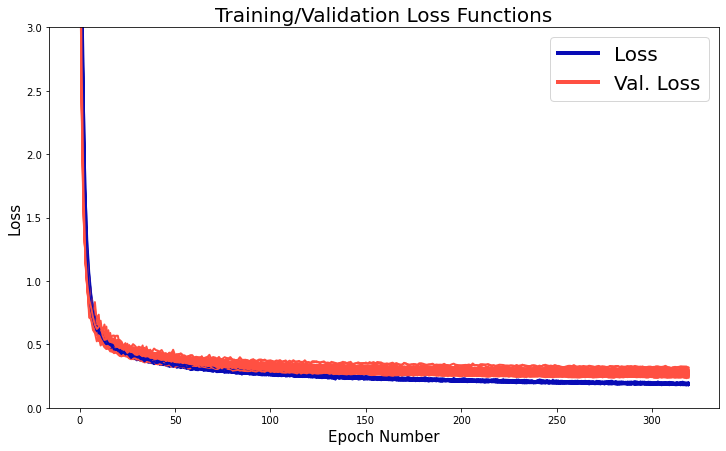

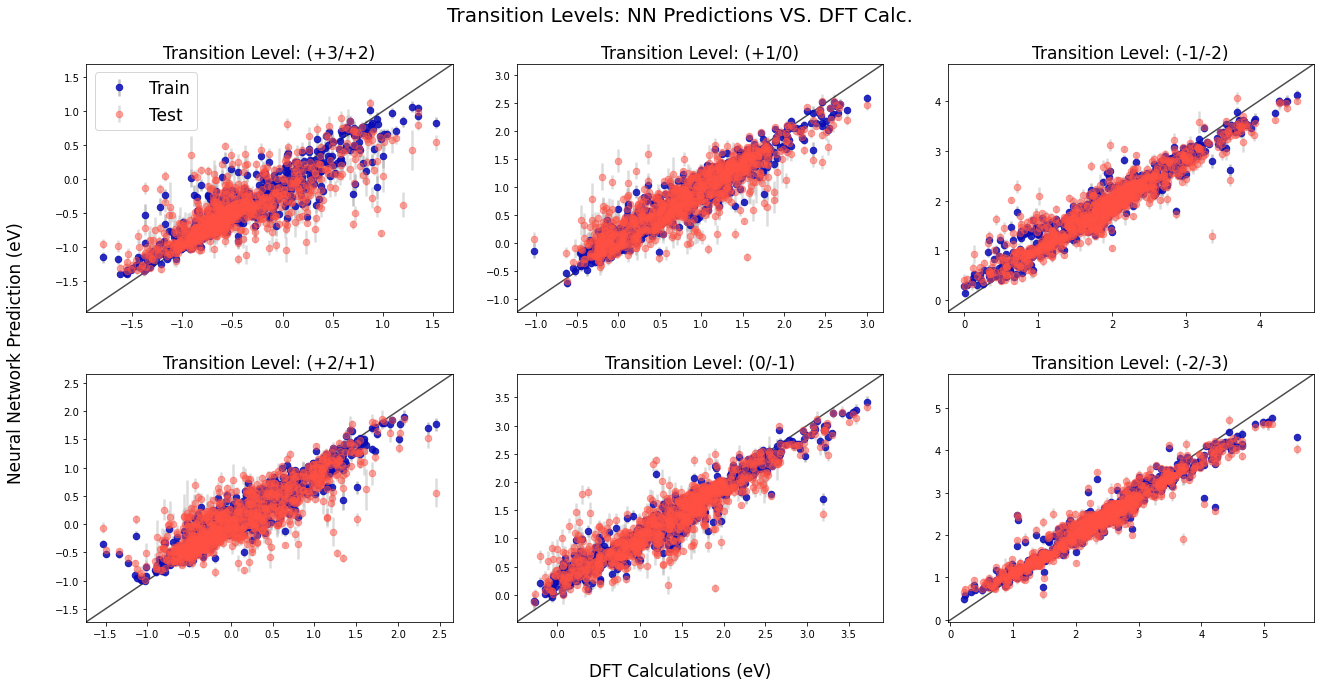

Average Train / Test RMSE with Uncertainty:
(+3/+2): 0.204 +/- 0.006   /   0.320 +/- 0.025
(+2/+1): 0.217 +/- 0.007   /   0.348 +/- 0.025
(+1/0): 0.208 +/- 0.007   /   0.332 +/- 0.020
(0/-1): 0.206 +/- 0.009   /   0.315 +/- 0.024
(-1/-2): 0.209 +/- 0.007   /   0.284 +/- 0.025
(-2/-3): 0.200 +/- 0.008   /   0.246 +/- 0.031

RMSE by defect site and SC type
---------------------------------------------------------
(+3/+2)
Sub site: 0.278 +/- 0.049
Int site: 0.339 +/- 0.027
IIVI type: 0.300 +/- 0.040
IIIV type: 0.370 +/- 0.052
IVIV type: 0.300 +/- 0.046
(+2/+1)
Sub site: 0.384 +/- 0.048
Int site: 0.324 +/- 0.029
IIVI type: 0.310 +/- 0.033
IIIV type: 0.366 +/- 0.052
IVIV type: 0.394 +/- 0.079
(+1/0)
Sub site: 0.421 +/- 0.039
Int site: 0.268 +/- 0.028
IIVI type: 0.310 +/- 0.035
IIIV type: 0.317 +/- 0.068
IVIV type: 0.380 +/- 0.058
(0/-1)
Sub site: 0.405 +/- 0.040
Int site: 0.247 +/- 0.037
IIVI type: 0.294 +/- 0.034
IIIV type: 0.342 +/- 0.063
IVIV type: 0.322 +/- 0.052
(-1/-2)
Sub site: 0.330

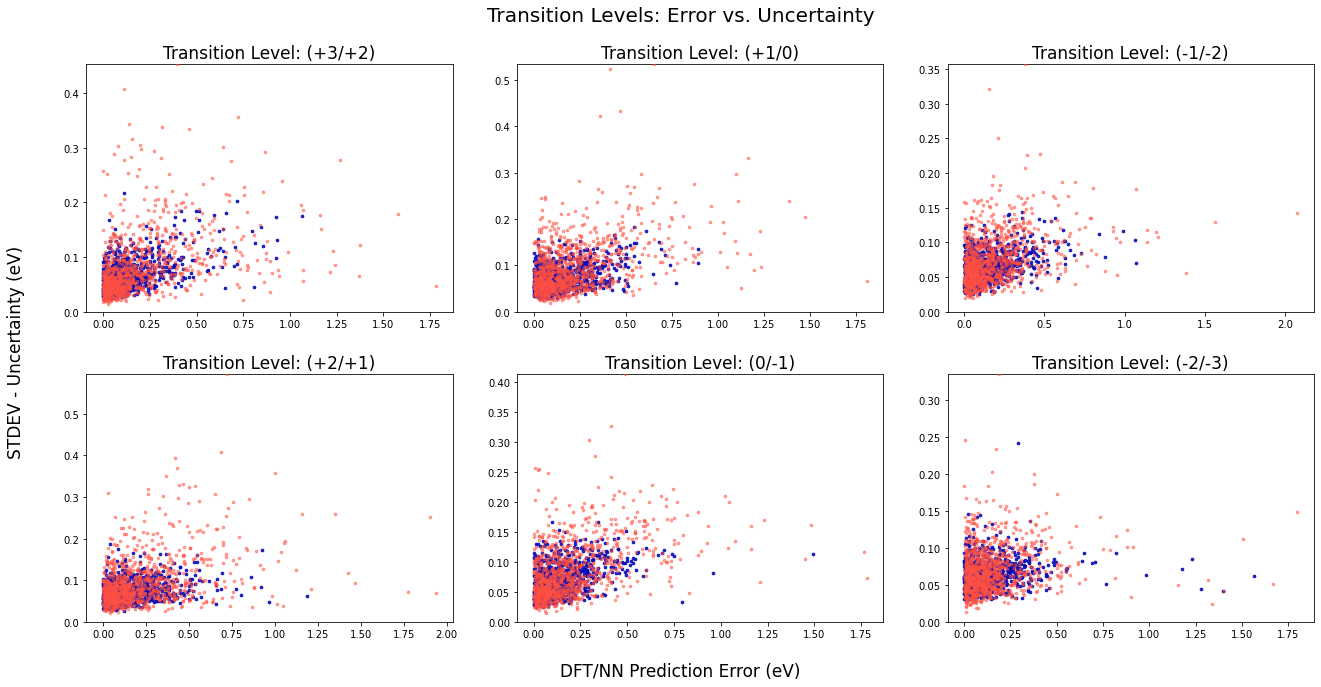

In [ ]:
# data preprocessing
df, output_scaler, input_scaler = NeuralNetwork.data_prep(df)
print("df columns: " + str(df.shape[1]))
print("")

# run k-fold
(train_result, test_result) = NeuralNetwork.run_k_fold(
    df, epochs=epochs, bs=batch_size, lr=learning_rate, decay=adam_decay,
    dropout=dropout, noise=noise, k_reg=kernal_regularizer, 
    hid_layer_neurons=hidden_neurons, verbose=verbose, folds=k_folds, 
    repeats=repetition, rs=random_state, graph=plot_graph, 
    output_scaler=output_scaler, input_scaler=input_scaler, df_full=df_full,
    beta1=beta1, beta2=beta2, amsgrad=amsgrad)